In [1]:
# import packages
import matplotlib.pyplot as plt
import numpy as np

from src import utils, figures, calculations, max_act_diff

### Example data:

Below we provide some example data.

The `filters` used should be extracted from the 3D CNN layer of the trained TG-CNN model.

The `input_tensors` are the graph representations of the individual patient pathways {INSERT TENSOR BUILDING GIF HERE}.

The `labels` are whether the patient had a positive (1) or negative (0) outcome.

Both the `filters` and the `input_tensors` should be 4D, `input_tensors` with shape (num_patients, num_timesteps,num_nodes, num_nodes) and `filters` with shape (num_filters, num_timesteps, num_nodes, num_nodes).

In [2]:
# Example Filters and Patients and Labels of whether they have a hip replacement (1) or not (0)

filters = np.array([[[[0, 0, 1], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 1, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]], 
                   [[[0, 1, 0], 
                    [0, 1, 0], 
                    [0, 0, 1]], [[1, 0, 0], 
                                 [0, 0, 0], 
                                 [0, 0, 0]]]])


input_tensors = np.array([[[[0, 0, 0], 
                          [0, 0, 3], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [0, 0, 0],
                                       [0, 4, 4]], [[0, 0, 0], 
                                                    [0, 2, 0], 
                                                    [0, 2, 0]], [[0, 0, 0], 
                                                                 [5, 0, 5], 
                                                                 [0, 0, 0]]],                        
                        [[[1, 0, 0], 
                          [1, 0, 0], 
                          [1, 0, 0]], [[0, 0, 0],
                                       [0, 8, 0],
                                       [0, 0, 0]], [[0, 11, 0], 
                                                    [0, 0, 0], 
                                                    [0, 11, 0]], [[0, 0, 30], 
                                                                 [0, 0, 30], 
                                                                 [0, 0, 30]]],                       
                          
                          [[[0, 0, 9], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 0],
                                       [7, 0, 0],
                                       [7, 0, 0]], [[0, 0, 0], 
                                                    [0, 0, 2], 
                                                    [0, 0, 0]], [[0, 0, 0], 
                                                                 [1, 0, 0], 
                                                                 [0, 0, 0]]],                          
                          [[[1, 1, 1], 
                          [0, 0, 0], 
                          [0, 0, 0]], [[0, 0, 1],
                                       [0, 0, 1],
                                       [0, 0, 0]], [[0, 0, 0], 
                                                    [0, 1, 0], 
                                                    [0, 1, 0]], [[0, 2, 0], 
                                                                 [0, 0, 0], 
                                                                 [0, 2, 0]]]]
                        
                        )


labels = [0, 1, 1, 0] #hip_replacement labels

### Calculate Maximum Activation Difference Between Hip Replacement and No Hip Replacement 

In [3]:
# def edge_activated_graph():

#     # 1. Get the maximum activation for each filter.
#     mean_activation_df = max_act_diff.max_act_diff_calc('Hip Replacement', input_tensors, filters, labels, verbose=False, show_plot=False)


In [14]:
mean_activation_df = max_act_diff.max_act_diff_calc('Hip Replacement', input_tensors, filters, labels, verbose=False, show_plot=False)

In [5]:
# Pick one patient graph to draw
patient_graph = utils.select_patient(input_tensors, 0)

In [6]:
max_act_filt = utils.get_max_act_filt(mean_activation_df, filters)

Filter 1 had the largest difference in activation.


In [7]:
act_graph = calculations.get_act_graph_array(patient_graph, max_act_filt)
act_graph

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 2., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]])

In [8]:
edges_df = utils.create_edges_df(patient_graph, act_graph)
edges_df

,start_node,end_node,activated,weight,time_between
0,1_v0,2_v1,0,0.5,3
1,2_v1,1_v2,0,0.5,4
2,2_v1,2_v2,0,0.5,4
3,1_v2,1_v3,1,2.0,2
4,2_v2,1_v3,0,0.5,2
5,1_v3,0_v4,0,0.5,5
6,1_v3,2_v4,0,0.5,5


In [9]:
pos_df = utils.create_position_df(edges_df)
pos_df

,node,x,cumulative_count,max_codes_per_visit
0,1_v0,0,0,1
1,2_v1,1,0,1
2,1_v2,2,0,2
3,2_v2,2,1,2
4,1_v3,3,0,1
5,0_v4,4,0,2
6,2_v4,4,1,2


In [10]:
pos_list = utils.generate_pos_sequence(pos_df['max_codes_per_visit'].max())
pos_list

[[0], [-1, 1]]

In [11]:
pos_df = utils.map_y_coord_to_node(pos_df, pos_list)
pos_df

,node,x,cumulative_count,max_codes_per_visit,y
0,1_v0,0,0,1,0
1,2_v1,1,0,1,0
2,1_v2,2,0,2,-1
3,2_v2,2,1,2,1
4,1_v3,3,0,1,0
5,0_v4,4,0,2,-1
6,2_v4,4,1,2,1


In [12]:
pos_dict = utils.create_pos_dict(pos_df)
pos_dict

{'1_v0': (0, 0),
 '2_v1': (1, 0),
 '1_v2': (2, -1),
 '2_v2': (2, 1),
 '1_v3': (3, 0),
 '0_v4': (4, -1),
 '2_v4': (4, 1)}

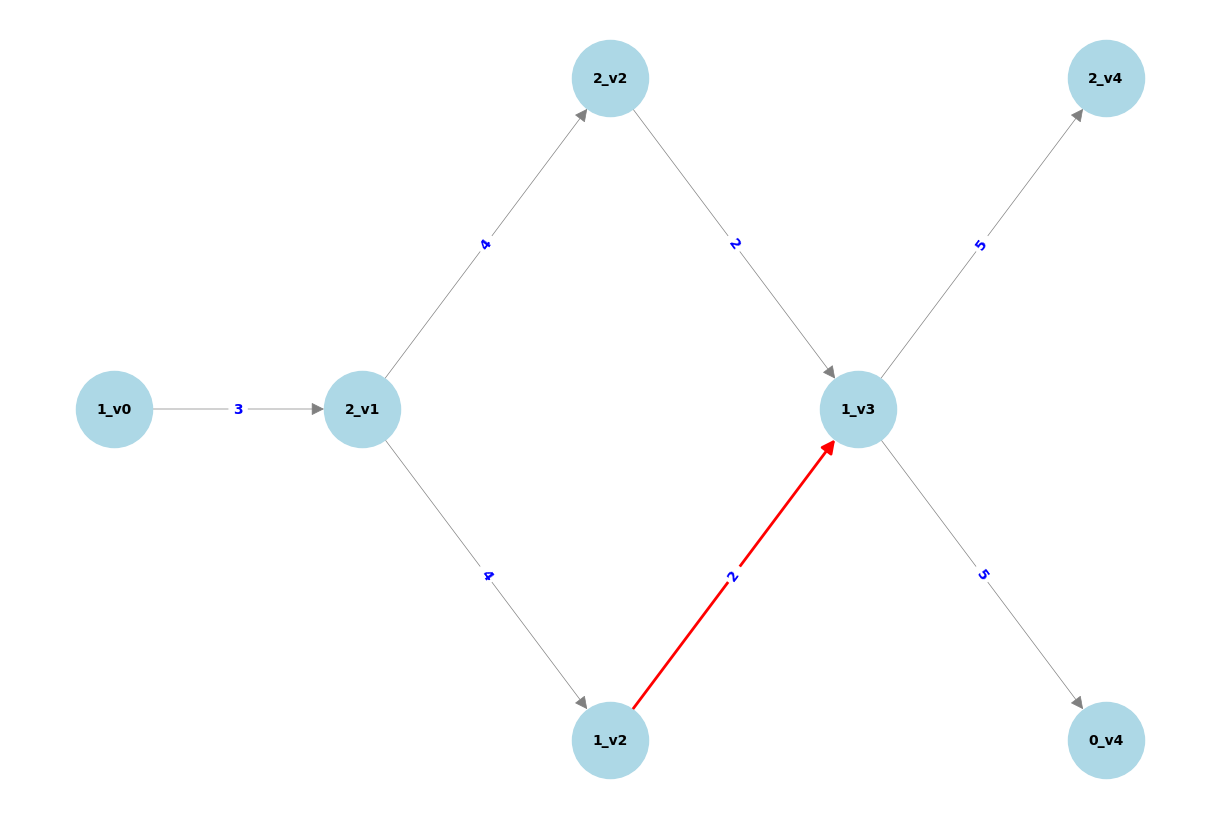

In [13]:
figures.draw_edge_activated_graph(edges_df, pos_dict)